Install required libraries

In [3]:
#!pip install kagglehub tensorflow transformers split-folders matplotlib


## Importing Libraries

In [4]:
import kagglehub
import os
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFViTForImageClassification, ViTConfig
from tensorflow.keras.optimizers import Adam

## Downloading The Dataset

In [5]:
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")
print("Path to dataset files:", path)

100%|██████████| 663M/663M [00:06<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3


In [6]:
dataset_dir = os.path.join(path, "TB_Chest_Radiography_Database")
print("Dataset directory:", dataset_dir)
print(os.listdir(dataset_dir))

Dataset directory: /root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database
['Normal', 'README.md.txt', 'Normal.metadata.xlsx', 'Tuberculosis', 'Tuberculosis.metadata.xlsx']


## Splitting The Data Into Train, Validation and Test

In [7]:
splitfolders.ratio(
    input=dataset_dir,  # The parent directory containing "Normal" and "Tuberculosis"
    output=os.path.join(path, "split"),  # Output directory for split data
    seed=42,
    ratio=(0.7, 0.2, 0.1),  # Train: 70%, Val: 20%, Test: 10%
    group_prefix=None
)

Copying files: 4200 files [00:02, 1954.03 files/s]


## Preprocessing the Data

In [20]:
def preprocess_dataset(dataset):
    # Resize images to (224, 224) and normalize pixel values to [0, 1]
    return dataset.map(
        lambda x, y: (tf.image.resize(x, (224, 224)) / 255.0, y)
    )

## Loading The Data Using Tensorflow

In [26]:
train_dataset1 = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(path, "split/train"),
    image_size=(224, 224),
    batch_size=32
)
val_dataset1 = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(path, "split/val"),
    image_size=(224, 224),
    batch_size=32
)
test_dataset1 = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(path, "split/test"),
    image_size=(224, 224),
    batch_size=32
)

Found 2939 files belonging to 2 classes.
Found 840 files belonging to 2 classes.
Found 421 files belonging to 2 classes.


## Applying preprocessing

In [27]:
train_dataset = preprocess_dataset(train_dataset1)
val_dataset = preprocess_dataset(val_dataset1)
test_dataset = preprocess_dataset(test_dataset1)

In [34]:
def fix_data_format(dataset):
    return dataset.map(lambda x, y: (tf.transpose(x, perm=[0, 3, 1, 2]), y))

In [35]:
train_dataset = fix_data_format(train_dataset)
val_dataset = fix_data_format(val_dataset)
test_dataset = fix_data_format(test_dataset)

## Verifying dataset shapes

In [36]:
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)

Image batch shape: (32, 3, 224, 224)


## Visualizing Some Images

Class Names: ['Normal', 'Tuberculosis']


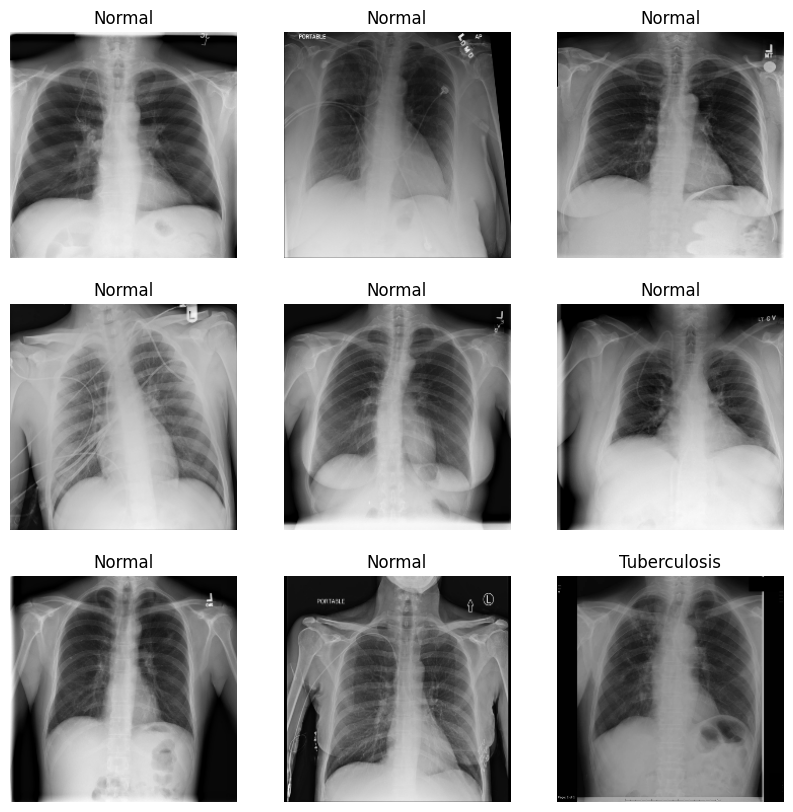

In [31]:
class_names = train_dataset1.class_names
print("Class Names:", class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Building the Model Using Hugging Face Transformers

In [37]:
# Define model configuration
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model = TFViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", config=config)

# Compile the model with optimizer as a string
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training The Model

In [38]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Epoch 1/10
92/92 [==============================] - 168s 1s/step - loss: 0.4748 - accuracy: 0.8217 - val_loss: 0.4458 - val_accuracy: 0.8357
Epoch 2/10
92/92 [==============================] - 126s 1s/step - loss: 0.4490 - accuracy: 0.8333 - val_loss: 0.4505 - val_accuracy: 0.8333
Epoch 3/10
92/92 [==============================] - 135s 1s/step - loss: 0.4551 - accuracy: 0.8336 - val_loss: 0.4518 - val_accuracy: 0.8333
Epoch 4/10
92/92 [==============================] - 126s 1s/step - loss: 0.4505 - accuracy: 0.8336 - val_loss: 0.4495 - val_accuracy: 0.8333
Epoch 5/10
92/92 [==============================] - 126s 1s/step - loss: 0.4491 - accuracy: 0.8336 - val_loss: 0.4432 - val_accuracy: 0.8333
Epoch 6/10
92/92 [==============================] - 126s 1s/step - loss: 0.4480 - accuracy: 0.8340 - val_loss: 0.4514 - val_accuracy: 0.8333
Epoch 7/10
92/92 [==============================] - 125s 1s/step - loss: 0.4500 - accuracy: 0.8336 - val_loss: 0.4625 - val_accuracy: 0.8333
Epoch 8/10
92

##  Evaluating the Model

In [39]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

14/14 [==============================] - 6s 407ms/step - loss: 0.4530 - accuracy: 0.8314
Test Accuracy: 83.14%


## Saving The Model

In [40]:
model.save_pretrained(f"{path}/tb_xray_model")